# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
'''
Слова и соседи - это дистрибутивная репрезентация

пусть есть 3 класса - '.', ',' '-ничего'

задача - какой знак ставит после Wc (W1 W1 Wc W7 W8)
Каждому слову в этой комбине сопоставляем 1 hot repr.
конкатенируем все векторы (получаем один длинный вектор)

----Данный подход хорош, так как не теряет инфу! (Но он пиздец много весит)----


на вход подаём индекс где, стоит единичка. Этот индекс будет доставить из матрицы нужный столбец, 
на который мы будем умножать! (torch.Embedding)

Sparse тензоры (в торче)

'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms
from word2vec_trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as _file:
            skipped_line = _file.readline() # skip the first line
            
            for line in _file:
                splitted_line = line.strip().split()
                line_without_number = splitted_line[1:]
                words = [word.lower() for word in line_without_number] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1 - np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
aims ['hampered', 'paralyzed', 'sounding']
after ['presence', 'another']
. ['mundane', 'disaster']
aborbing ['arguable', 'case']
are ['conceive', 'roles']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [3]:
class Word2VecPlain(Dataset):
    def __init__(self, data, num_contexts=30000):
        self.data = data
        self.num_contexts = num_contexts
        self.num_tokens = len(data.index_by_token)
        self.samples = []

    
    def generate_dataset(self, context_length=5):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        for step in range(self.num_contexts):
            center_word, context_words = data.get_random_context(context_length)

            for word in context_words:
                sample = (self.data.index_by_token[center_word], self.data.index_by_token[word])
                self.samples.append(sample)
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)
    
    def __getitem__(self, index):
        input_index, output_index = self.samples[index]
        input_vector = torch.zeros(self.num_tokens)
        input_vector[input_index] = 1.0
        return input_vector, output_index
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample

dataset = Word2VecPlain(data, 20)
dataset.generate_dataset()
print(dataset.samples)

[(7670, 15343), (7670, 1236), (7670, 7671), (7670, 18935), (9138, 17221), (9138, 12399), (5377, 1484), (5377, 5376), (8909, 8910), (8909, 8911), (9778, 9777), (9778, 3517), (9778, 5146), (9778, 9779), (236, 1514), (236, 1803), (236, 692), (236, 4), (11806, 795), (11806, 11805), (11806, 11807), (11806, 11808), (8849, 87), (8849, 7544), (413, 145), (413, 6964), (413, 2626), (128, 6736), (128, 16000), (128, 32), (12582, 12581), (12582, 12583), (12582, 6897), (2241, 18914), (2241, 8963), (2241, 18915), (2241, 14541), (137, 209), (137, 915), (15212, 10420), (15212, 9035), (5195, 5194), (5195, 269), (5195, 5196), (5195, 5197), (6504, 1283), (6504, 15), (6504, 6505), (6504, 203), (9712, 408), (9712, 14477), (5173, 2174), (5173, 5040), (9277, 3361), (9277, 11450), (207, 628), (207, 1361), (207, 16081)]


In [4]:
dataset = Word2VecPlain(data, 20)
dataset.generate_dataset()
input_vector, target = dataset[19]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 2155


# Создаем модель и тренируем ее

In [5]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [6]:
def extract_word_vectors(nn_model):
    input_vectors, output_vectors = nn_model[0].weight.T, nn_model[1].weight
    return torch.clone(input_vectors), torch.clone(output_vectors)


untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [7]:
cude = "cuda:0"
device = torch.device('cpu') # Let's make sure GPU is available!
device

device(type='cpu')

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

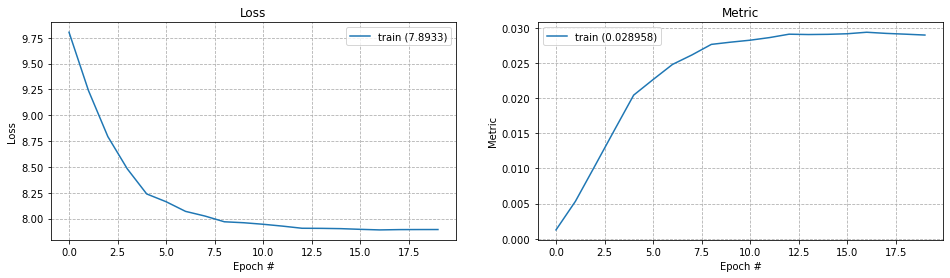

In [16]:
# Finally, let's train the model!
# TODO: We use placeholder values for hyperparameters - you will need to find better values!

dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset(30)
batchsize=2500

nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)


optimizer = optim.Adagrad(nn_model.parameters(), lr=3e-1, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

trainer = Trainer(model=nn_model, train_loader=train_loader, dataset=dataset, batchsize=batchsize)
trainer.train(opt=optimizer,
              loss_fn=loss,
              device=device,
              metric_fn=Trainer.accuracy,
              scheduler=scheduler,
              epochs=20)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

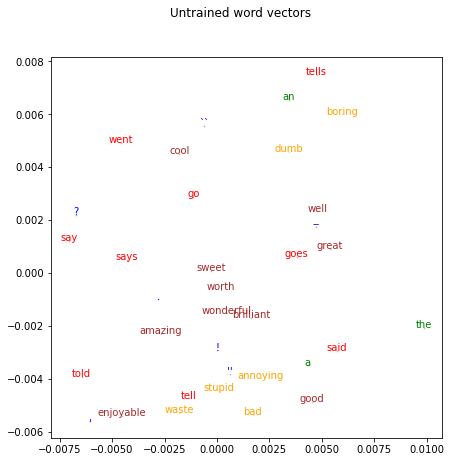

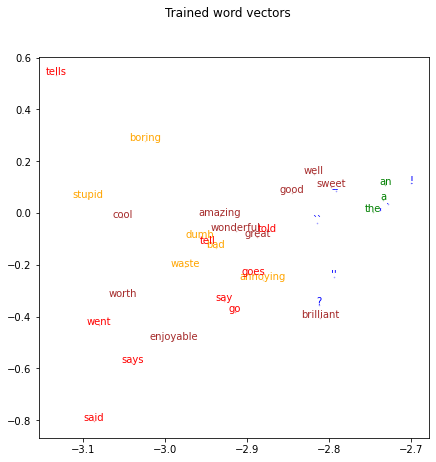

In [17]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.cpu().detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")